In [1]:
import os
import sys
sys.path.append(r"/n/home09/dsprague/Ponce_rotation")
from core.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.GAN_invert_utils import GAN_invert
from core.utils.GAN_utils import upconvGAN
#%% 
# Set parameters
refimgdir = r"/n/home09/dsprague/data/gan_invert_test"

save_dir = r"/n/home09/dsprague/data/gan_invert_test_preprocess"
os.makedirs(save_dir, exist_ok=True)
refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=256)
for imgid in range(len(refimgnms)):
    img = ToPILImage()(refimgtsr[imgid])
    file_name = refimgnms[imgid].split('.')[0]
    image_format = "png"
    img.save(join(save_dir, f"{file_name}.{image_format}"))

/n/home09/dsprague/.conda/envs/ponce_rotation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/n/home09/dsprague/Ponce_rotation/core/utils/GAN_utils.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  SD = torch.load(savepath[name])
loss: 0.013: 100%|██████████| 50

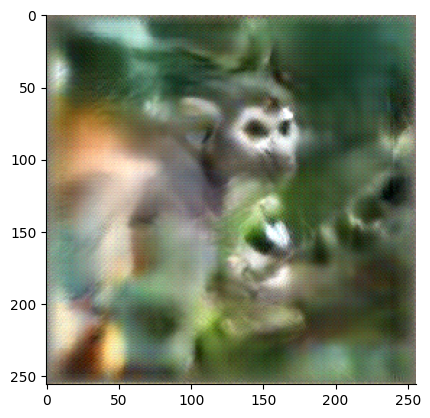

In [2]:

save_dir = r"/n/home09/dsprague/data/gan_invert_output"
os.makedirs(save_dir, exist_ok=True)
G = upconvGAN("fc6").cuda().eval()
for imgid in range(len(refimgnms)):
        targnm, target_imgtsr_real = refimgnms[imgid], refimgtsr[imgid:imgid + 1]

        target_img = target_imgtsr_real[0]

        z_opts, img_opts= GAN_invert(G, target_img.cuda(), max_iter=int(5E4),
                                print_progress=False, batch_size = 1)
        #imgs = resize_and_pad_tsr(img_opts, (147, 147), (40, 40))
        imgs = img_opts
        plt.imshow(ToPILImage()(imgs[0]))
        file_name = refimgnms[imgid].partition(".")[0]
        image_format = "png"
        img = ToPILImage()(imgs[0])
        img.save(join(save_dir, f"{file_name}.{image_format}"))

## Old code ?? 

In [ ]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
import torch.nn.functional as F

#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "resnet50" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.layer3.5.BatchNorm2dbn3']#'.BatchNorm2dbn3', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "--"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 1000
score_method = "cosine"

G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
imgid = 1
target_imgtsr_real =  refimgtsr[imgid:imgid + 1]

img_opts_rsz = F.interpolate(img_opts.cpu(), size=(227, 227))
imgid = 2
target_imgtsr = img_opts_rsz[imgid:imgid + 1]
init_code = np.array(z_opts.detach().cpu()[imgid:imgid + 1])

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
#unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
#               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

targ_actmat_real, target_imgtsr_real_resize = encode_image(scorer_random, target_imgtsr_real, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"

#set objective function
objfunc = set_objective('inflate_unit', targ_actmat, unit_id=60, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=init_code, Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
    run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None,
            meta_data_df=None, trial_param_dict=None, init_code=init_code,
            titlestr =title_str, steps=10, RFresize=True, corner=pading_size, imgsize=img_size,
            RF_mask=fitdict_random["fitmap"], save_plot=None)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)

#plot the actmat
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(targ_actmat_real[0], label="real", color="red")
ax.plot(targ_actmat[0], label="invert", color="blue")
ax.legend()

scorer_random.cleanup()

In [ ]:
popact_norm = np.linalg.norm(targ_actmat, axis=1,keepdims=True)
targact_norm = np.linalg.norm(targ_actmat_real, axis=1,keepdims=True)
scores = ((targ_actmat @ targ_actmat_real.T) / popact_norm / targact_norm).squeeze(axis=1)
print("final coisne score: ", scores.mean())

In [ ]:
scores = - np.square(targ_actmat_real - targ_actmat).mean(axis=1)
print("final MSE score: ", scores.mean())

In [ ]:
actmat_all[-1,:].shape

In [ ]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "resnet50" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.layer3.5.BatchNorm2dbn3']#, '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "--"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 1000
score_method = "cosine"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 2

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
#unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
#                scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()
